# Recessions

Note: Recessions cannot be determined algorithmically. Many factors need to be considered.

## Set-up

In [1]:
import pandas as pd
from pandas import DataFrame
import readabs as ra
from matplotlib.patches import Patch
from plotting import set_chart_dir, clear_chart_dir, finalise_plot

In [2]:
# pandas display settings
pd.options.display.max_rows = 999999
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 100

# save charts in this notebook
CHART_DIR = "./CHARTS/Recessions/"
set_chart_dir(CHART_DIR)
clear_chart_dir(CHART_DIR)

# some plotting constants
CAT, CAT_GDP = "1364.0.15.003", "5206.0"
LFOOTER = "Australia. "
RFOOTER = f"ABS: {CAT}."
RFOOTER_GDP = f"ABS: {CAT_GDP}."
RFOOTER_BOTH = f"ABS: {CAT}, {CAT_GDP}."

# display charts in this notebook
SHOW = True

## Get the main data items

In [3]:
def get_data() -> tuple[dict[str, pd.Series], pd.DataFrame]:
    """Get a dictionary of data items from the ABS."""

    aggregates = "5206001_Key_Aggregates"
    wanted = {
        # "Series ID": ["Category ID", "single-excel-only table name", "Short Series Title"],
        "A2454517C": [CAT, "", "Labour force"],
        "A2454521V": [CAT, "", "Unemployed"],
        "A2454489F": [CAT, "", "GDP"],  # Chain volume measures, seasonally adjusted
        "A2302460K": [CAT_GDP, aggregates, "GDP per capita"],
        "A2302459A": [CAT_GDP, aggregates, "GDP-Orig"],
    }

    data, meta = {}, {}
    for series_id, (category_id, seo, title) in wanted.items():
        d, m = ra.read_abs_series(category_id, series_id, single_excel_only=seo)
        data[title] = d[series_id]
        meta[title] = m.loc[series_id]
    return data, pd.DataFrame(meta).T

### Calculations

In [4]:
def build_dataset() -> DataFrame:
    """Build a dataset from the ABS data."""

    def two_negative_quarters(series):
        """Identify two consecutive negative quarters."""
        return (series < 0) & ((series.shift(-1) < 0) | (series.shift(1) < 0))

    data_dict, meta = get_data()
    data = pd.DataFrame(data_dict)

    data["population"] = data["GDP-Orig"] / data["GDP per capita"]
    data["Employed"] = data["Labour force"] - data["Unemployed"]
    data["Employment Growth"] = data["Employed"].pct_change(1) * 100
    data["Unemployment Rate"] = data["Unemployed"] / data["Labour force"] * 100
    data["GDP Growth"] = data["GDP"].pct_change() * 100
    data["GDP Recession"] = two_negative_quarters(data["GDP Growth"])
    data["Employment Recession"] = two_negative_quarters(data["Employment Growth"])
    data["GDP per Capita"] = data["GDP"] / data["population"]
    data["GDP per Capita Growth"] = data["GDP per Capita"].pct_change() * 100
    data["GDP per Capita Recession"] = two_negative_quarters(
        data["GDP per Capita Growth"]
    )

    # unemployment growth
    threshold = 0.5
    data["Rapid Unemployment Growth"] = data["Unemployment Rate"].rolling(4).min().shift(1) < data["Unemployment Rate"] - threshold
    return data, threshold

DATA, THRESHHOLD = build_dataset()

## Plot

### Utility for plotting

In [5]:
def highlight(ax, series, color, alpha=0.5) -> None:
    """Add highlights to a chart based on a Boolean series."""

    shading, start, previous = False, None, None
    for index, item in series.items():
        if item and not shading:
            shading, start = True, index
        if shading and not item:
            ax.axvspan(start, previous, color=color, alpha=alpha)
            shading = False
        previous = index
    if shading:
        ax.axvspan(start, previous, color=color, alpha=alpha)

In [6]:
def hack_legend(ax, color, alpha, label) -> None:
    """Add a dummy entry to the legend to allow for a title."""

    patch = Patch(facecolor=color, alpha=alpha, label=label)
    handles, _labels = ax.get_legend_handles_labels()
    _lgd = ax.legend(handles=[handles[0], patch], loc="best", fontsize=8)

In [7]:
# constants
R_COLOUR, ALPHA = "darkorange", 0.5

### Technical recessions in GDP growth

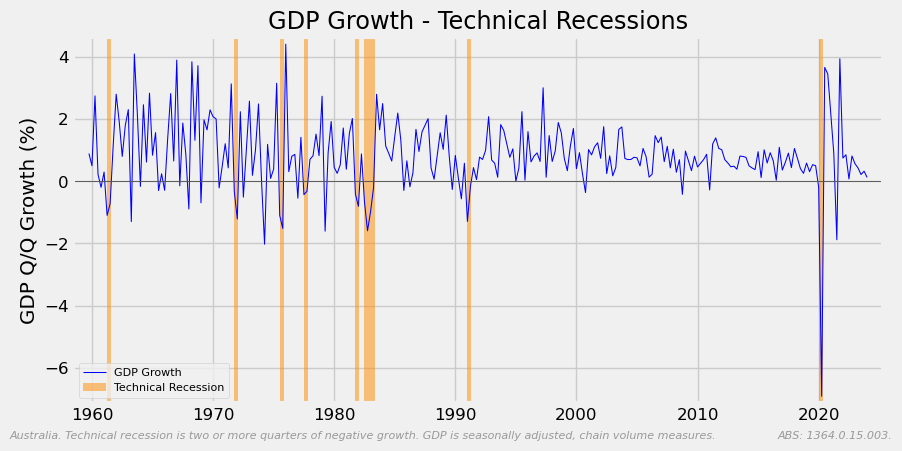

In [8]:
def plot_gdp_tech_rec(data: DataFrame = DATA) -> None:
    """Plot GDP growth and technical recessions."""

    # Technical recession periods
    ax = data["GDP Growth"].plot(lw=0.75, c="blue")
    highlight(ax, data["GDP Recession"], color=R_COLOUR, alpha=ALPHA)
    hack_legend(ax, R_COLOUR, ALPHA, "Technical Recession")

    finalise_plot(
        ax,
        title="GDP Growth - Technical Recessions",
        ylabel="GDP Q/Q Growth (%)",
        y0=True,
        rfooter=RFOOTER,
        lfooter=f"{LFOOTER}Technical recession is two or more quarters of negative growth. "
        + "GDP is seasonally adjusted, chain volume measures. ",
        show=SHOW,
    )


plot_gdp_tech_rec()

### Technical recessions in employment growth

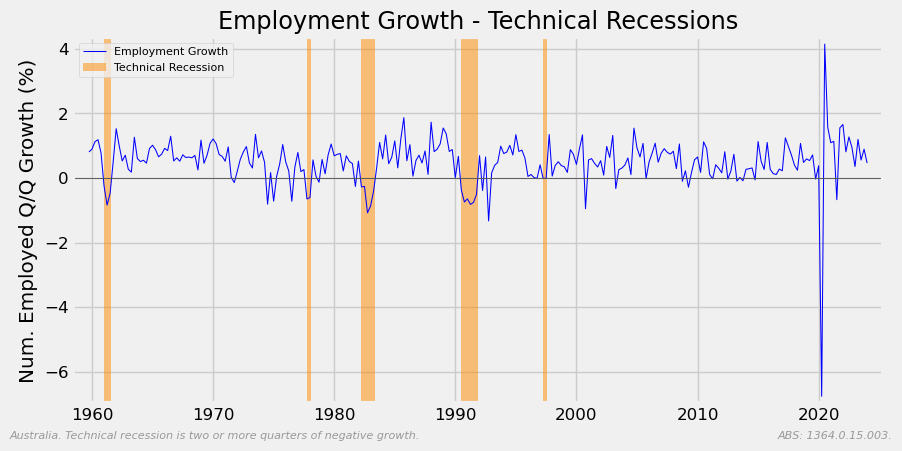

In [9]:
def plot_emp_tech_rec(data: DataFrame = DATA) -> None:
    """Plot employment growth and technical recessions."""

    ax = data["Employment Growth"].plot(lw=0.75, c="blue")
    highlight(ax, data["Employment Recession"], color=R_COLOUR, alpha=ALPHA)
    hack_legend(ax, R_COLOUR, ALPHA, "Technical Recession")

    finalise_plot(
        ax,
        title="Employment Growth - Technical Recessions",
        ylabel="Num. Employed Q/Q Growth (%)",
        y0=True,
        rfooter=RFOOTER,
        lfooter=f"{LFOOTER}Technical recession is two or more quarters of negative growth. ",
        show=SHOW,
    )


plot_emp_tech_rec()

### Technical recessions in GDP per capita growth

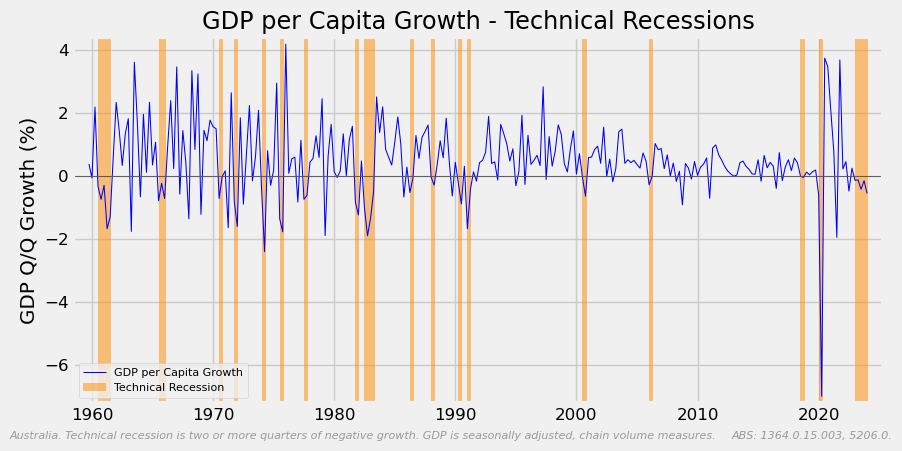

In [10]:
def plot_gdppc_tech_rec(data: DataFrame = DATA) -> None:
    """Plot GDP per capita growth and technical recessions."""

    ax = data["GDP per Capita Growth"].plot(lw=0.75, c="blue")
    highlight(ax, data["GDP per Capita Recession"], color=R_COLOUR, alpha=ALPHA)
    hack_legend(ax, R_COLOUR, ALPHA, "Technical Recession")

    finalise_plot(
        ax,
        title="GDP per Capita Growth - Technical Recessions",
        ylabel="GDP Q/Q Growth (%)",
        y0=True,
        rfooter=RFOOTER_BOTH,
        lfooter=f"{LFOOTER}Technical recession is two or more quarters of negative growth. "
        "GDP is seasonally adjusted, chain volume measures. ",
        show=SHOW,
    )


plot_gdppc_tech_rec()

### Periods of high growth in the unemployment rate

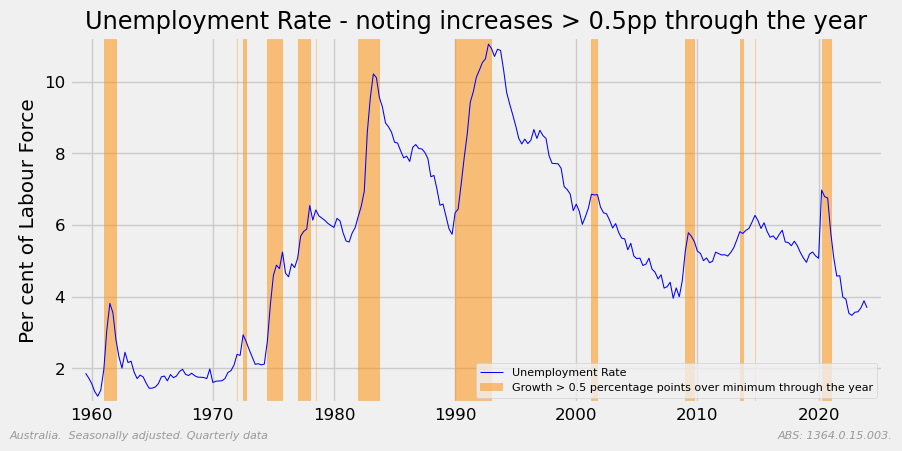

In [11]:
def plot_unemployment(data: DataFrame = DATA) -> None:
    """Plot the unemployment rate and highlight rapid increases."""

    # increase in the unemployment rate
    ax = data["Unemployment Rate"].plot(lw=0.75, c="blue")
    issues = data["Rapid Unemployment Growth"]
    highlight(ax, issues, color=R_COLOUR, alpha=ALPHA)
    hack_legend(
        ax, R_COLOUR, ALPHA, f"Growth > {THRESHHOLD} percentage points over minimum through the year"
    )

    finalise_plot(
        ax,
        title=f"Unemployment Rate - noting increases > {THRESHHOLD}pp through the year",
        ylabel="Per cent of Labour Force",
        y0=True,
        rfooter=RFOOTER,
        lfooter=f"{LFOOTER} Seasonally adjusted. Quarterly data",
        show=SHOW,
    )


plot_unemployment()

## The end

In [12]:
# watermark
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Thu Jul 11 2024 22:02:59

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

pandas : 2.2.2
readabs: 0.0.8a0

Watermark: 2.4.3

